# Workaround Example for Misplaced Spectral Aperture in NIRSpec Products
--------------------------------------------------------------------------------------------------------
**Latest update**: August 7, 2023.

## Notebook Goals
Extract a 1D spectrum at the assumed source location.

## Introduction

This workaround is intended to address a known issue with NIRSpec pipeline products: the extraction aperture is offset along the spatial axis, resulting in a 1D extracted spectrum with low or negative signal, even though the source is visible in the 2D spectral image.

This notebook uses as an example a commissioning observation from program 1125: a nodded and dithered fixed slit observation of point source IRAS 05248-7007 with filter F290LP, grating G395H, and slit S200A1.

Only the final products from the level 3 pipeline for fixed slit or MOS modes are updated here. If earlier products from the level 2 pipeline are needed, they can be updated similarly.

Use this workaround until the pipeline releases a fix to the extraction algorithm, or as needed to manually set an extraction aperture.

**NOTE**: The method demonstrated here for correcting the automated source location is still being tested, but preliminary results suggest that it is robust for MOS and fixed slit data for both level 2 and level 3 products.

## Set up

Import necessary packages.

In [1]:
import json
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

from jwst.extract_1d import extract, Extract1dStep

warnings.simplefilter('ignore', RuntimeWarning)

Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
spec3_name = 'jw01125-o001_s00001_nirspec_f290lp-g395h-s200a1-subs200a1'

# get 1D and 2D spectral products for the final spec3 output
x1d_names = [f'{spec3_name}_x1d.fits']
s2d_names = [f'{spec3_name}_s2d.fits']

# download all the FITS files
for name in x1d_names + s2d_names:
    print(f'Downloading {name}')
    get_jwst_file(name)

## Patch the extraction location method

For point sources, the current pipeline default is to use the target location in RA and Dec and the celestial WCS associated with the spectral image to determine the aperture location. For a variety of reasons, either the source RA/Dec or the WCS may be inaccurate in absolute position.

Instead of using the sky position, we can use the relative slit position of the target, as planned in APT, to place the aperture.  Following a successful target acquisition, this position is typically known with high accuracy (~5-10 mas).

Patch the ExtractModel, used to determine the aperture location, with the alternate algorithm.

In [4]:
class PatchedExtractModel(extract.ExtractModel):
    def locn_from_wcs(self, input_model, slit, *args):
        """Get the location of the spectrum, based on the WCS.

        Parameters
        ----------
        input_model : data model
            The input science model.

        slit : one slit from a MultiSlitModel (or similar), or None
            The WCS and target coordinates will be gotten from `slit`
            unless `slit` is None, and in that case they will be gotten
            from `input_model`.

        Returns
        -------
        tuple (middle, middle_wl, locn) or None
        middle : int
            Pixel coordinate in the dispersion direction within the 2-D
            cutout (or the entire input image) at the middle of the WCS
            bounding box.  This is the point at which to determine the
            nominal extraction location, in case it varies along the
            spectrum.  The offset will then be the difference between
            `locn` (below) and the nominal location.

        middle_wl : float
            The wavelength at pixel `middle`.

        locn : float
            Pixel coordinate in the cross-dispersion direction within the
            2-D cutout (or the entire input image) that has right ascension
            and declination coordinates corresponding to the target location.
            The spectral extraction region should be centered here.

        None will be returned if there was not sufficient information
        available, e.g. if the wavelength attribute or wcs function is not
        defined.
        """
        bb = self.wcs.bounding_box  # ((x0, x1), (y0, y1))

        if bb is None:
            if slit is None:
                shape = input_model.data.shape
            else:
                shape = slit.data.shape

            bb = wcs_bbox_from_shape(shape)

        # Width (height) in the cross-dispersion direction, from the start of the 2-D cutout (or of the full image)
        # to the upper limit of the bounding box.
        # This may be smaller than the full width of the image, but it's all we need to consider.
        xd_width = int(round(bb[1][1]))  # must be an int
        middle = int((bb[0][0] + bb[0][1]) / 2.)  # Middle of the bounding_box in the dispersion direction.
        x = np.empty(xd_width, dtype=np.float64)
        x[:] = float(middle)
        y = np.arange(xd_width, dtype=np.float64)
        lower = bb[1][0]
        upper = bb[1][1]

        # We need stuff[2], a 1-D array of wavelengths crossing the spectrum near its middle.
        fwd_transform = self.wcs(x, y)
        middle_wl = np.nanmean(fwd_transform[2])

        if slit is None:
            xpos = input_model.source_xpos
            ypos = input_model.source_ypos
        else:
            xpos = slit.source_xpos
            ypos = slit.source_ypos

        slit2det = self.wcs.get_transform('slit_frame', 'detector')
        x_y = slit2det(xpos, ypos, middle_wl)

        # locn is the XD location of the spectrum:
        locn = x_y[1]

        # If the target is at the edge of the image or at the edge of the non-NaN area, we can't use the WCS to find the
        # location of the target spectrum.
        if locn < lower or locn > upper:
            log.warning(f"WCS implies the target is at {locn:.2f}, which is outside the bounding box,")
            log.warning("so we can't get spectrum location using the WCS")
            locn = None

        return middle, middle_wl, locn

extract.ExtractModel = PatchedExtractModel

## Extract a new spectrum

Using the updated aperture location method, we can extract a new spectrum from the 2D spectral image.

In [5]:
auto_x1d_names = []
for s2d in s2d_names:
    step = Extract1dStep()
    new_spectrum = step(s2d)

    x1d_name = s2d.replace('s2d', 'x1d_auto')
    new_spectrum.save(x1d_name)
    auto_x1d_names.append(x1d_name)

2023-08-07 12:41:52,201 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-08-07 12:41:52,235 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('jw01125-o001_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_s2d.fits',).
2023-08-07 12:41:52,236 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 

Plot the old and new 1D spectrum.

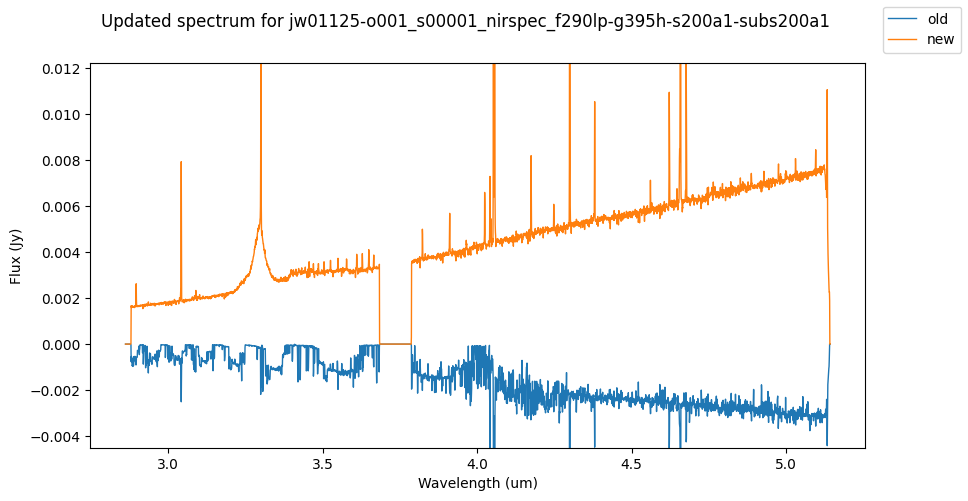

In [6]:
def compare_spectra(spec1_names, spec2_names, label1='old', label2='new', scale_percent=0.2):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.suptitle(f'Updated spectrum for {spec3_name}')
    
    # pipeline extracted spectrum
    all_flux = np.array([])
    for i, name in enumerate(spec1_names):
        with fits.open(name) as hdulist:
            for extnum in range(len(hdulist)):
                hdu = hdulist[extnum]
                if hdu.name == 'EXTRACT1D':
                    data = hdu.data
                    header = hdu.header
                    flux_plot = ax.plot(data['WAVELENGTH'], data['FLUX'], linewidth=1, label=label1)
                    
                    ax.set_xlabel(f"Wavelength ({header['TUNIT1']})")
                    ax.set_ylabel(f"Flux ({header['TUNIT2']})")
                    all_flux = np.hstack([all_flux, data['FLUX']])
    
    # new extracted spectrum
    for i, name in enumerate(spec2_names):
        with fits.open(name) as hdulist:
            for extnum in range(len(hdulist)):
                hdu = hdulist[extnum]
                if hdu.name == 'EXTRACT1D':
                    data = hdu.data
                    header = hdu.header
                    flux_plot = ax.plot(data['WAVELENGTH'], data['FLUX'], linewidth=1, label=label2)
                    
                    ax.set_xlabel(f"Wavelength ({header['TUNIT1']})")
                    ax.set_ylabel(f"Flux ({header['TUNIT2']})")
                    all_flux = np.hstack([all_flux, data['FLUX']])
    
    ax.set_ylim([np.nanpercentile(all_flux, scale_percent), 
                 np.nanpercentile(all_flux, 100 - scale_percent)])

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) < 20:
        fig.legend()

compare_spectra(x1d_names, auto_x1d_names)

## Check the extracted aperture location

We can get the extracted aperture location from the logged information and plot it with the s2d file to verify the location is accurate.

Get the aperture location from the log message above, and identify the extension and image to plot.

In [7]:
ystart = 25.78830134189159
ystop = 30.78830134189159
extnum = 1
s2d_file = s2d_names[0]

Plot the central 200 pixels of the image with the aperture overlaid.

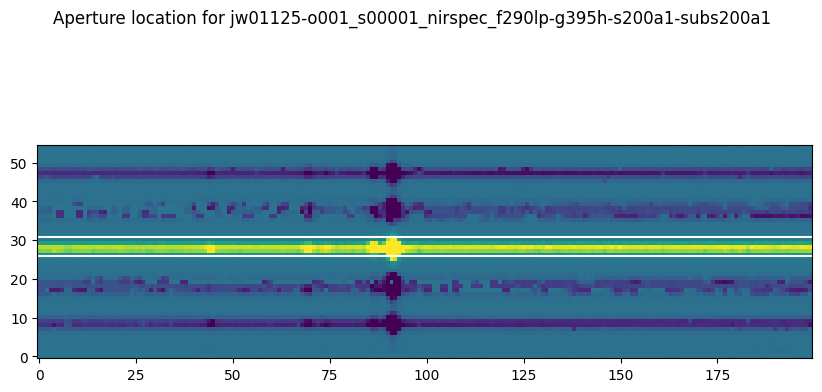

In [8]:
def image_with_aperture(y1, y2, window=100):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.suptitle(f'Aperture location for {spec3_name}')
    
    with fits.open(s2d_file) as hdulist:
        hdu = hdulist[extnum]
        x_center = hdu.data.shape[1] // 2
        vmin = np.nanpercentile(hdu.data, 1)
        vmax = np.nanpercentile(hdu.data, 99)
    
        ax.imshow(hdu.data[:, x_center - window:x_center + window], origin='lower', vmin=vmin, vmax=vmax)
        ax.axhline(y1, color='white')
        ax.axhline(y2, color='white')

image_with_aperture(ystart, ystop)

## Tweak the extraction location

The assumed source position should work well for most NIRSpec sources, but in case the extraction aperture is still poorly placed, it can be manually tweaked by specifying start and stop positions to the extraction step.

Extraction parameters are set in a reference file in JSON format, described in the [pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html).  Here, we'll use the minimum necessary configuration for explicitly setting the start and stop values for the aperture.

Re-extract the spectrum with a slightly wider aperture.

In [9]:
new_ystart = 23
new_ystop = 33
slit = "ANY"
override_file = 'override_x1d.json'

override = {"apertures": [{"id": slit, "ystart": new_ystart, "ystop": new_ystop}]}
with open(override_file, 'w') as fp:
    json.dump(override, fp)

In [10]:
manual_x1d_names = []
for s2d in s2d_names:
    step = Extract1dStep()
    step.use_source_posn = False
    step.override_extract1d = override_file
    
    new_spectrum = step(s2d)

    x1d_name = s2d.replace('s2d', 'x1d_manual')
    new_spectrum.save(x1d_name)
    manual_x1d_names.append(x1d_name)

2023-08-07 12:41:57,160 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-08-07 12:41:57,207 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('jw01125-o001_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_s2d.fits',).
2023-08-07 12:41:57,208 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': False, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001,

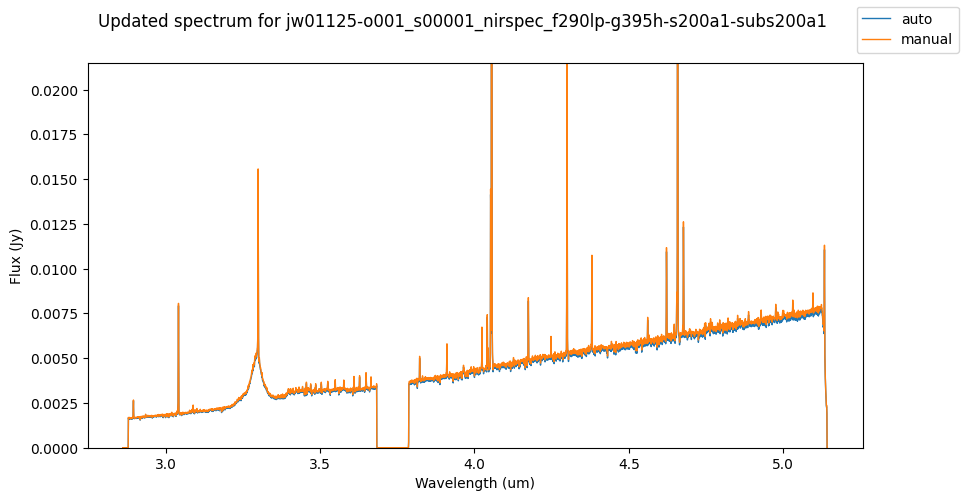

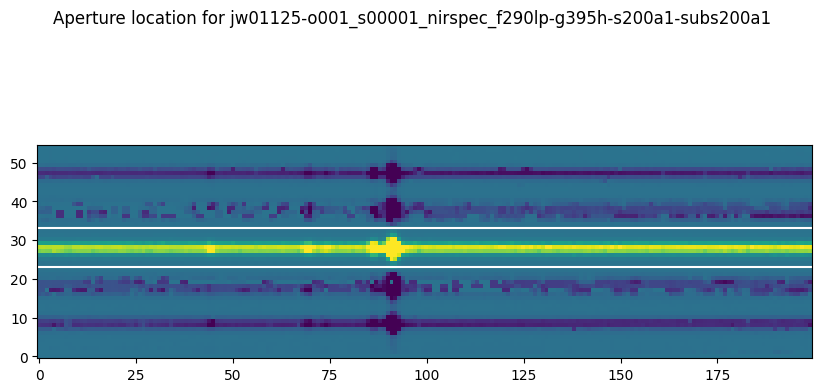

In [11]:
compare_spectra(auto_x1d_names, manual_x1d_names, label1='auto', label2='manual')
image_with_aperture(new_ystart, new_ystop)